# TFRS Two-tower Ranking Model on ML-1m

## 1. Introduction

**Real-world recommender systems are often composed of two stages:**

 * The retrieval stage (Selects recommendation candidates): is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.

 * The ranking stage (Selects the best candidates and rank them): takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.


In this Notebook, we're going to build and train such a ranking model using the Movielens dataset (1m Dataset).

We're going to:

 * Get our data and split it into a training and test set.
 * Implement a ranking model.
 * Fit and evaluate it.


## 2. Dataset

**Movie Lens** contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by [GroupLens](https://grouplens.org/) , a research group at the University of Minnesota. There are 5 versions included: "25m", "latest-small", "100k", "1m", "20m". In all datasets, the movies data and ratings data are joined on "movieId". The 25m dataset, latest-small dataset, and 20m dataset contain only movie data and rating data. The 1m dataset and 100k dataset contain demographic data in addition to movie and rating data.

**movie_lens/1m** can be treated in two ways:

  * It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of *implicit feedback*, where users' watches tell us which things they prefer to see and which they'd rather not see (This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example).
  * It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of *explicit feedback*: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.



**[movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings):**
 * Config description: This dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens. Ratings are in whole-star increments. This dataset contains demographic data of users in addition to data on movies and ratings.
 * This dataset is the largest dataset that includes demographic data from movie_lens.
 * "user_gender": gender of the user who made the rating; a true value corresponds to male
 * "bucketized_user_age": bucketized age values of the user who made the rating, the values and the corresponding ranges are:
   * 1: "Under 18"
   * 18: "18-24"
   * 25: "25-34"
   * 35: "35-44"
   * 45: "45-49"
   * 50: "50-55"
   * 56: "56+"
 * "user_occupation_label": the occupation of the user who made the rating represented by an integer-encoded label; labels are preprocessed to be consistent across different versions
 * "user_occupation_text": the occupation of the user who made the rating in the original string; different versions can have different set of raw text labels
 * "user_zip_code": the zip code of the user who made the rating.
 * Download size: 5.64 MiB
 * Dataset size: 308.42 MiB
 * Auto-cached ([documentation](https://www.tensorflow.org/datasets/performances#auto-caching)): No
 * Features:
 ```
 FeaturesDict({
               'bucketized_user_age': tf.float32,
               'movie_genres': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=21)),
               'movie_id': tf.string,
               'movie_title': tf.string,
               'raw_user_age': tf.float32,
               'timestamp': tf.int64,
               'user_gender': tf.bool,
               'user_id': tf.string,
               'user_occupation_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=22),
               'user_occupation_text': tf.string,
               'user_rating': tf.float32,
               'user_zip_code': tf.string,
              })
 ```
**Example:**

|bucketized_user_age	|movie_genres|	movie_id|	movie_title|	raw_user_age|	timestamp|	user_gender|	user_id	|user_occupation_label|	user_occupation_text	|user_rating	|user_zip_code|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|45.0	|7 (Drama)|b'357'	|b"One Flew Over the Cuckoo's Nest (1975)"	|46.0	|879024327	|True	|b'138'	|4 (doctor/health care)	|b'doctor'	|4.0|	b'53211'|


## 3. Sourcing and Loading

### 3.1 Import relevant libraries

In [ ]:
!pip install -q tensorflow_recommenders

In [ ]:
# Import the necessary Libararies: 

import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text
from keras.constraints import maxnorm

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

### 3.2 Preparing the dataset

Let's first have a look at the data.

We use the MovieLens dataset from Tensorflow Datasets. Loading **[movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings)** yields a ***tf.data.Dataset*** object.

Note that since the MovieLens dataset does not have predefined splits, all data are under train split.

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)


In [ ]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([16], dtype=int64),
 'movie_id': b'2762',
 'movie_title': b'Sixth Sense, The (1999)',
 'timestamp': 974584897,
 'user_gender': True,
 'user_id': b'2262',
 'user_occupation_label': 18,
 'user_occupation_text': b'technician/engineer',
 'user_rating': 4.0,
 'user_zip_code': b'48116'}


In [ ]:
type(ratings)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

Next, As you can see below, in the map function, the ratings are considered explicit feedback since we can tell roughly how much the users like the movies based on the rating numbers.

In [ ]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_title": x["movie_title"],
                                 "user_id": x["user_id"],
                                 "user_rating": x["user_rating"]
                                })



In [ ]:
len(ratings)

1000209

In [ ]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [ ]:
# Now, let's find out how many uniques users/movies:
movie_titles = ratings.batch(l).map(lambda x: x["movie_title"])
user_ids = ratings.batch(l).map(lambda x: x["user_id"])

#Movies uniques:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

#users unique
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# take a look at the movies:
unique_movie_titles[:10]

array([b'$1,000,000 Duck (1971)', b"'Night Mother (1986)",
       b"'Til There Was You (1997)", b"'burbs, The (1989)",
       b'...And Justice for All (1979)', b'1-900 (1994)',
       b'10 Things I Hate About You (1999)', b'101 Dalmatians (1961)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)'], dtype=object)

In [ ]:
#Movies uniques
len_films = len(unique_movie_titles)
print(len_films) 

3706


In [ ]:
#users unique
len_users = len(unique_user_ids)
print(len_users) 

6040


## 4. Implementing a Ranking Model:

**2 Dense Layers + embedding_dimension = 32 + epochs = 3**

Ranking models do not face the same efficiency constraints as retrieval models do, and so we have a little bit more freedom in our choice of architectures.

A model composed of multiple stacked dense layers is a relatively common architecture for ranking tasks. We can implement it as follows:

In [ ]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
                               tf.keras.layers.experimental.preprocessing.StringLookup(
                               vocabulary=unique_user_ids, mask_token=None),
                               tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                                  ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_movie_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
                                                   ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                                          # Learn multiple dense layers.
                                          tf.keras.layers.Dense(256, activation="relu"),
                                          tf.keras.layers.Dense(64, activation="relu"),
                                          # Make rating predictions in the final layer.
                                          tf.keras.layers.Dense(1)
                                          ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

This model takes user ids and movie titles, and outputs a predicted rating:

In [ ]:
RankingModel()((["42"], ["7th Voyage of Sinbad, The (1958)"]))


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01835283]], dtype=float32)>

Overall, our ranking model takes in a user ID and a movie title and outputs a predicted rating. As we can see above, using our untrained model, user 42 is predicted to give "7th Voyage of Sinbad, The (1958)" a rating of 0.033. 

### 4.1 Loss and metrics:

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the **Ranking** task object: a convenience wrapper that bundles together the loss function and metric computation.

We'll use it together with the **MeanSquaredError** Keras loss in order to predict the ratings.


In [ ]:
task = tfrs.tasks.Ranking(
                         loss = tf.keras.losses.MeanSquaredError(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()]
                         )

The task itself is a Keras layer that takes true and predicted as arguments, and returns the computed loss. We'll use that to implement the model's training loop.

### 4.2 The full model

We can now put it all together into a model. TFRS exposes a base model class [(tfrs.models.Model)](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/models/Model) which streamlines bulding models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model



In [ ]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                                                              loss = tf.keras.losses.MeanSquaredError(),
                                                               metrics=[tf.keras.metrics.RootMeanSquaredError()]
                                                              )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model((features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

### 4.3 Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

**Adagrad** is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing smaller updates
(i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e. high learning rates) for parameters associated with infrequent features. **For this reason, it is well-suited for dealing with sparse data.**

Let's first instantiate the model.

In [ ]:
#Let's first instantiate the model.
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train = model.fit(cached_train, validation_data = cached_test, epochs=3)

Epoch 1/3
92/92 [==============================] - 36s 227ms/step - root_mean_squared_error: 1.2698 - loss: 1.6049 - regularization_loss: 0.0000e+00 - total_loss: 1.6049 - val_root_mean_squared_error: 1.0699 - val_loss: 1.0821 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0821
Epoch 2/3
92/92 [==============================] - 2s 23ms/step - root_mean_squared_error: 1.0186 - loss: 1.0361 - regularization_loss: 0.0000e+00 - total_loss: 1.0361 - val_root_mean_squared_error: 0.9807 - val_loss: 0.9176 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9176
Epoch 3/3
92/92 [==============================] - 2s 24ms/step - root_mean_squared_error: 0.9535 - loss: 0.9081 - regularization_loss: 0.0000e+00 - total_loss: 0.9081 - val_root_mean_squared_error: 0.9319 - val_loss: 0.8102 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8102


Now, we can compile and train the model using the fit method. You can see that the loss is falling and the RMSE metric is improving.

### 4.4 Visualization: Total loss and RMSE over epochs

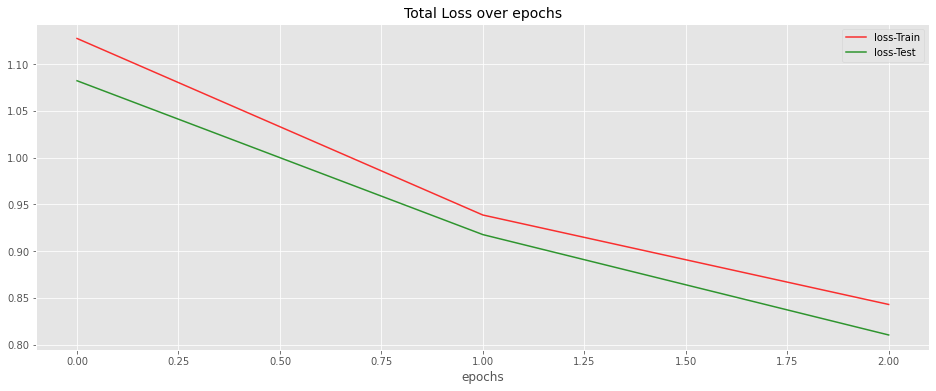

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


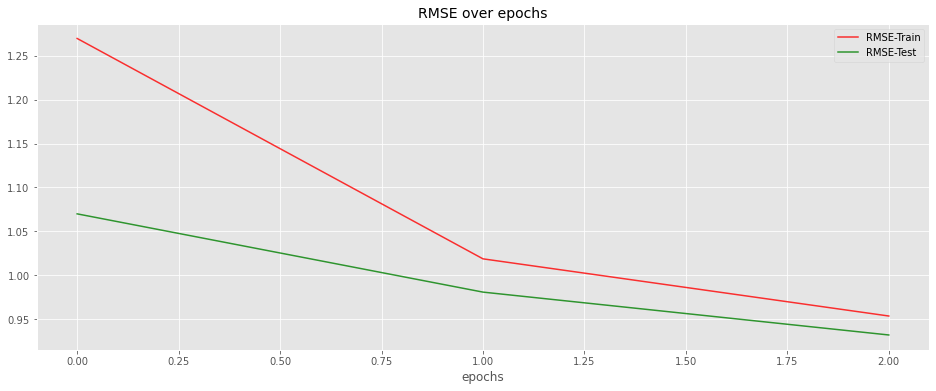

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Evaluate the model
model.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 0s 3ms/step - root_mean_squared_error: 0.9319 - loss: 0.8675 - regularization_loss: 0.0000e+00 - total_loss: 0.8675


{'root_mean_squared_error': 0.9318667650222778,
 'loss': 0.8102383017539978,
 'regularization_loss': 0,
 'total_loss': 0.8102383017539978}

The lower the RMSE metric, the more accurate our model is at predicting ratings.

## 5. Ranking Tuning

### 5.1 Two Dense Layers + embedding_dimension = 64 + epochs = 32

In [ ]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
        embedding_dimension = 64

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
                               tf.keras.layers.experimental.preprocessing.StringLookup(
                               vocabulary=unique_user_ids, mask_token=None),
                               tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                                  ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_movie_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
                                                   ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                                          # Learn multiple dense layers.
                                          tf.keras.layers.Dense(256, activation="relu"),
                                          tf.keras.layers.Dense(64, activation="relu"),
                                          # Make rating predictions in the final layer.
                                          tf.keras.layers.Dense(1)
                                          ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
RankingModel()((["42"], ["7th Voyage of Sinbad, The (1958)"]))


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03304617]], dtype=float32)>

In [ ]:
task = tfrs.tasks.Ranking(
                         loss = tf.keras.losses.MeanSquaredError(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()]
                         )

In [ ]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                                                              loss = tf.keras.losses.MeanSquaredError(),
                                                               metrics=[tf.keras.metrics.RootMeanSquaredError()]
                                                              )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model((features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [ ]:
#Let's first instantiate the model.
model_1 = MovielensModel()
model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train_1 = model_1.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
92/92 [==============================] - 38s 271ms/step - root_mean_squared_error: 1.2461 - loss: 1.5458 - regularization_loss: 0.0000e+00 - total_loss: 1.5458 - val_root_mean_squared_error: 1.0557 - val_loss: 1.1432 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1432
Epoch 2/32
92/92 [==============================] - 4s 39ms/step - root_mean_squared_error: 1.0111 - loss: 1.0209 - regularization_loss: 0.0000e+00 - total_loss: 1.0209 - val_root_mean_squared_error: 0.9703 - val_loss: 0.9552 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9552
Epoch 3/32
92/92 [==============================] - 4s 39ms/step - root_mean_squared_error: 0.9461 - loss: 0.8954 - regularization_loss: 0.0000e+00 - total_loss: 0.8954 - val_root_mean_squared_error: 0.9592 - val_loss: 0.9399 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9399error: 0.9534 - loss: 0.9091 - regularization - ETA: 0s - root_mean_squared_error: 0.9461 - loss: 0.8951 - regularization_loss: 0.00

92/92 [==============================] - 6s 63ms/step - root_mean_squared_error: 0.8976 - loss: 0.8053 - regularization_loss: 0.0000e+00 - total_loss: 0.8053 - val_root_mean_squared_error: 0.8990 - val_loss: 0.8571 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8571
Epoch 29/32
92/92 [==============================] - 6s 65ms/step - root_mean_squared_error: 0.8973 - loss: 0.8047 - regularization_loss: 0.0000e+00 - total_loss: 0.8047 - val_root_mean_squared_error: 0.8988 - val_loss: 0.8559 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8559
Epoch 30/32
92/92 [==============================] - 6s 65ms/step - root_mean_squared_error: 0.8969 - loss: 0.8041 - regularization_loss: 0.0000e+00 - total_loss: 0.8041 - val_root_mean_squared_error: 0.8986 - val_loss: 0.8547 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8547
Epoch 31/32
92/92 [==============================] - 6s 66ms/step - root_mean_squared_error: 0.8965 - loss: 0.8033 - regularization_loss: 0.00

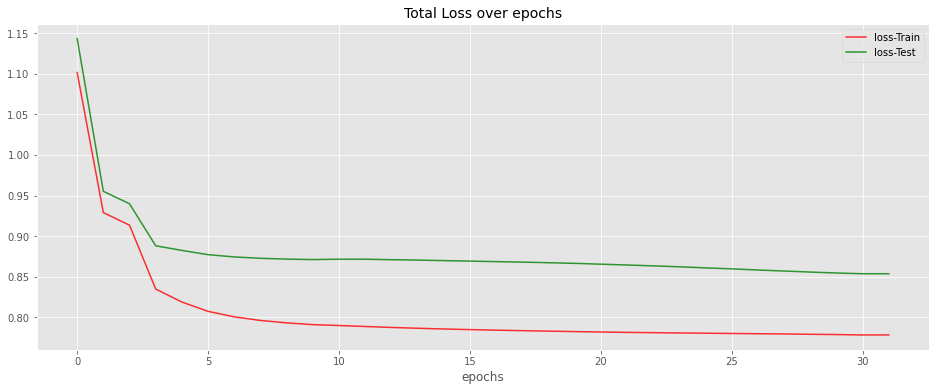

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train_1.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


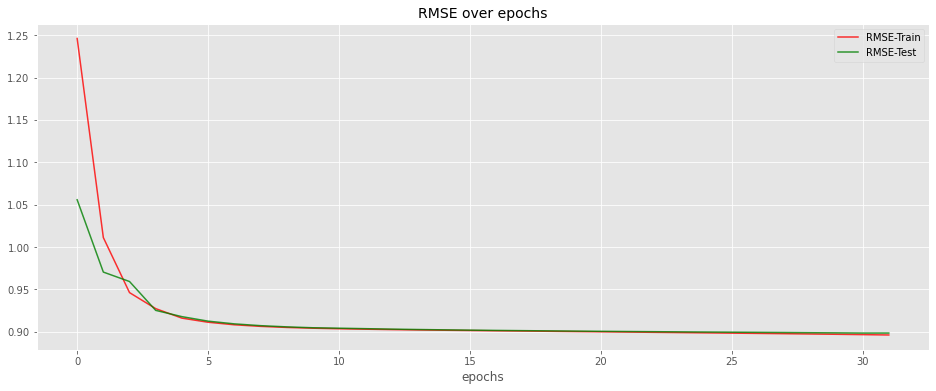

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train_1.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Evaluate the model
model_1.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 1s 7ms/step - root_mean_squared_error: 0.8984 - loss: 0.8078 - regularization_loss: 0.0000e+00 - total_loss: 0.8078


{'root_mean_squared_error': 0.8983687162399292,
 'loss': 0.8537996411323547,
 'regularization_loss': 0,
 'total_loss': 0.8537996411323547}

### 5.2 Deeper Network: 3 Dense Layers + embedding_dimension = 64 + epochs = 32

In [ ]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
        embedding_dimension = 64

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
                               tf.keras.layers.experimental.preprocessing.StringLookup(
                               vocabulary=unique_user_ids, mask_token=None),
                               tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                                  ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_movie_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
                                                   ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                                          # Learn multiple dense layers.
                                          tf.keras.layers.Dense(128, activation="relu"),
                                          tf.keras.layers.Dense(128, activation="relu"),
                                          tf.keras.layers.Dense(64, activation="relu"),
                                          # Make rating predictions in the final layer.
                                          tf.keras.layers.Dense(1)
                                          ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
RankingModel()((["42"], ["7th Voyage of Sinbad, The (1958)"]))


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01368098]], dtype=float32)>

In [ ]:
task = tfrs.tasks.Ranking(
                         loss = tf.keras.losses.MeanSquaredError(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()]
                         )

In [ ]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                                                              loss = tf.keras.losses.MeanSquaredError(),
                                                               metrics=[tf.keras.metrics.RootMeanSquaredError()]
                                                              )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model((features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [ ]:
#Let's first instantiate the model.
model_2 = MovielensModel()
model_2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train_2 = model_2.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
92/92 [==============================] - 42s 314ms/step - root_mean_squared_error: 1.3079 - loss: 1.7031 - regularization_loss: 0.0000e+00 - total_loss: 1.7031 - val_root_mean_squared_error: 1.1005 - val_loss: 1.1245 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1245
Epoch 2/32
92/92 [==============================] - 4s 48ms/step - root_mean_squared_error: 1.0581 - loss: 1.1177 - regularization_loss: 0.0000e+00 - total_loss: 1.1177 - val_root_mean_squared_error: 0.9918 - val_loss: 0.9704 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9704
Epoch 3/32
92/92 [==============================] - 5s 56ms/step - root_mean_squared_error: 0.9624 - loss: 0.9251 - regularization_loss: 0.0000e+00 - total_loss: 0.9251 - val_root_mean_squared_error: 0.9293 - val_loss: 0.9321 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9321
Epoch 4/32
92/92 [==============================] - 5s 57ms/step - root_mean_squared_error: 0.9277 - loss: 0.8604 - regularization_

92/92 [==============================] - 10s 109ms/step - root_mean_squared_error: 0.8783 - loss: 0.7710 - regularization_loss: 0.0000e+00 - total_loss: 0.7710 - val_root_mean_squared_error: 0.8822 - val_loss: 0.8302 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8302
Epoch 30/32
92/92 [==============================] - 10s 109ms/step - root_mean_squared_error: 0.8753 - loss: 0.7657 - regularization_loss: 0.0000e+00 - total_loss: 0.7657 - val_root_mean_squared_error: 0.8773 - val_loss: 0.8157 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8157
Epoch 31/32
92/92 [==============================] - 10s 107ms/step - root_mean_squared_error: 0.8760 - loss: 0.7669 - regularization_loss: 0.0000e+00 - total_loss: 0.7669 - val_root_mean_squared_error: 0.8758 - val_loss: 0.7974 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.7974
Epoch 32/32
92/92 [==============================] - 9s 102ms/step - root_mean_squared_error: 0.8758 - loss: 0.7664 - regularization_los

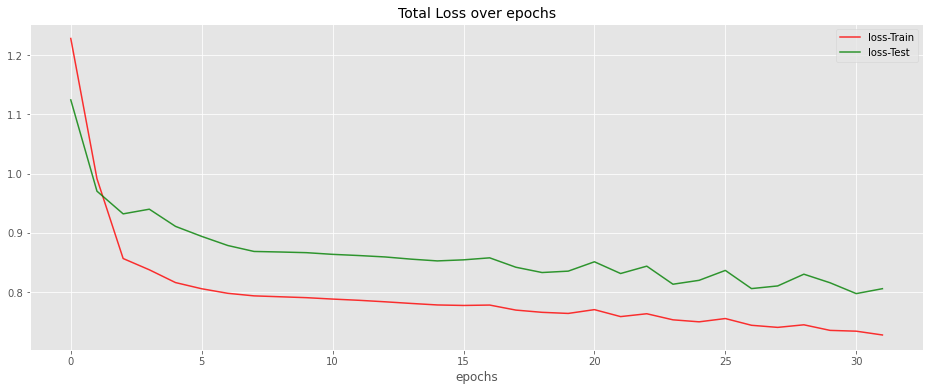

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train_2.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


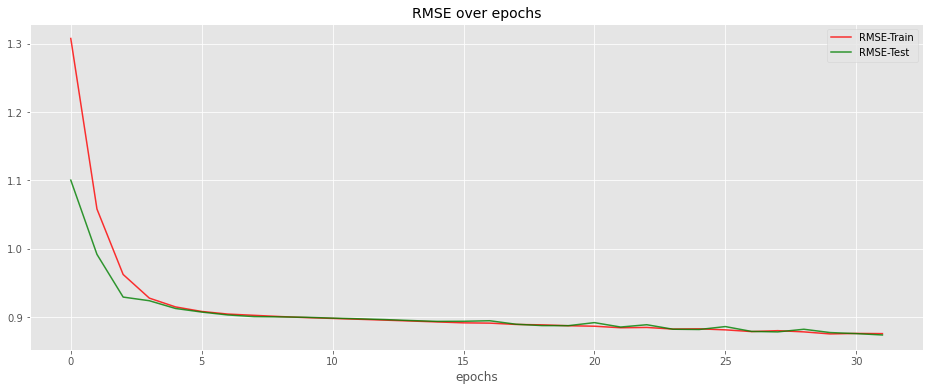

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train_2.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Evaluate the model
model_2.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 1s 9ms/step - root_mean_squared_error: 0.8738 - loss: 0.7642 - regularization_loss: 0.0000e+00 - total_loss: 0.7642


{'root_mean_squared_error': 0.8737925887107849,
 'loss': 0.8057142496109009,
 'regularization_loss': 0,
 'total_loss': 0.8057142496109009}

### 5.3 Deeper Network: 4 Dense Layers + embedding_dimension = 64 + epochs = 32

In [ ]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
        embedding_dimension = 64

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
                               tf.keras.layers.experimental.preprocessing.StringLookup(
                               vocabulary=unique_user_ids, mask_token=None),
                               tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                                  ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_movie_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
                                                   ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                                          # Learn multiple dense layers.
                                          tf.keras.layers.Dense(128, activation="relu"),
                                          tf.keras.layers.Dense(128, activation="relu"),
                                          tf.keras.layers.Dense(128, activation="relu"),
                                          tf.keras.layers.Dense(64, activation="relu"),
                                          # Make rating predictions in the final layer.
                                          tf.keras.layers.Dense(1)
                                          ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
RankingModel()((["42"], ["7th Voyage of Sinbad, The (1958)"]))


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01385202]], dtype=float32)>

In [ ]:
task = tfrs.tasks.Ranking(
                         loss = tf.keras.losses.MeanSquaredError(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()]
                         )

In [ ]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                                                              loss = tf.keras.losses.MeanSquaredError(),
                                                               metrics=[tf.keras.metrics.RootMeanSquaredError()]
                                                              )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model((features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [ ]:
#Let's first instantiate the model.
model_3 = MovielensModel()
model_3.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train_3 = model_3.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
92/92 [==============================] - 48s 376ms/step - root_mean_squared_error: 1.4066 - loss: 1.9673 - regularization_loss: 0.0000e+00 - total_loss: 1.9673 - val_root_mean_squared_error: 1.1129 - val_loss: 1.0904 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0904
Epoch 2/32
92/92 [==============================] - 7s 71ms/step - root_mean_squared_error: 1.0978 - loss: 1.2029 - regularization_loss: 0.0000e+00 - total_loss: 1.2029 - val_root_mean_squared_error: 1.0236 - val_loss: 0.9517 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9517
Epoch 3/32
92/92 [==============================] - 7s 72ms/step - root_mean_squared_error: 0.9864 - loss: 0.9719 - regularization_loss: 0.0000e+00 - total_loss: 0.9719 - val_root_mean_squared_error: 0.9431 - val_loss: 0.8265 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8265
Epoch 4/32
92/92 [==============================] - 7s 71ms/step - root_mean_squared_error: 0.9343 - loss: 0.8725 - regularization_

92/92 [==============================] - 12s 131ms/step - root_mean_squared_error: 0.8734 - loss: 0.7623 - regularization_loss: 0.0000e+00 - total_loss: 0.7623 - val_root_mean_squared_error: 0.8751 - val_loss: 0.6761 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6761
Epoch 30/32
92/92 [==============================] - 12s 132ms/step - root_mean_squared_error: 0.8736 - loss: 0.7628 - regularization_loss: 0.0000e+00 - total_loss: 0.7628 - val_root_mean_squared_error: 0.8756 - val_loss: 0.6674 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6674
Epoch 31/32
92/92 [==============================] - 12s 132ms/step - root_mean_squared_error: 0.8718 - loss: 0.7595 - regularization_loss: 0.0000e+00 - total_loss: 0.7595 - val_root_mean_squared_error: 0.8690 - val_loss: 0.6615 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6615
Epoch 32/32
92/92 [==============================] - 13s 140ms/step - root_mean_squared_error: 0.8697 - loss: 0.7558 - regularization_lo

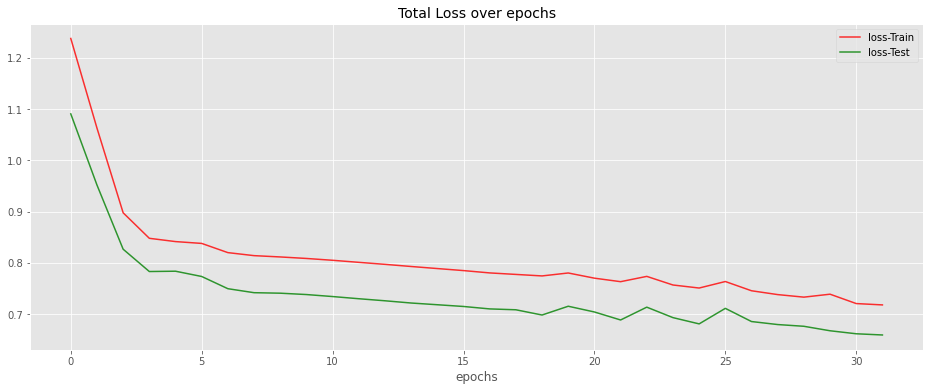

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_3.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train_3.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


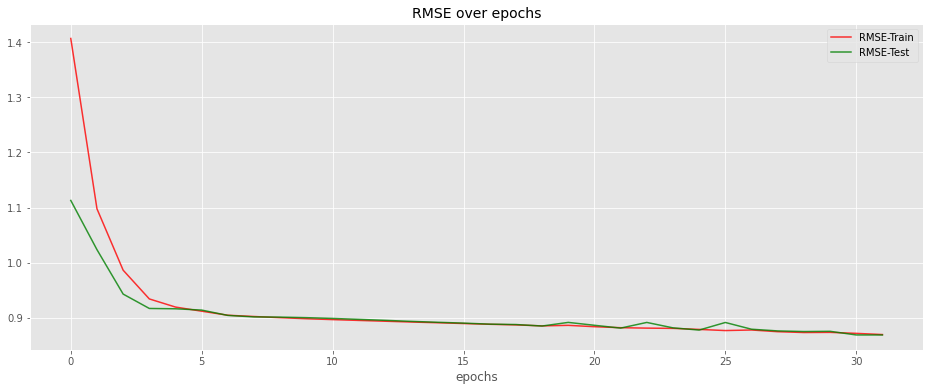

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_3.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train_3.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Evaluate the model
model_3.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 1s 6ms/step - root_mean_squared_error: 0.8689 - loss: 0.7535 - regularization_loss: 0.0000e+00 - total_loss: 0.7535


{'root_mean_squared_error': 0.8689167499542236,
 'loss': 0.6591469645500183,
 'regularization_loss': 0,
 'total_loss': 0.6591469645500183}

### 5.4 Deeper Network: Adding weight Constraint (Maximum Norm) and Dropout

**4 Dense Layers + embedding_dimension = 64 + epochs = 32**

 * Let's add weight constraint, which imposes a hard rule on the weights, max norm that forces the vector norm of the weights to be below a value=3. Once exceeded all weights in the node are made small enough to meet the constraint.
 * Let's add Dropout: Generally, using a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.

In [ ]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
        embedding_dimension = 64

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
                               tf.keras.layers.experimental.preprocessing.StringLookup(
                               vocabulary=unique_user_ids, mask_token=None),
                               tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                                  ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_movie_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
                                                   ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
                                          # Learn multiple dense layers.

                                          tf.keras.layers.Dense(128, kernel_constraint=maxnorm(3), activation="relu"),
                                          layers.Dropout(0.3),
                                          tf.keras.layers.Dense(128, kernel_constraint=maxnorm(3), activation="relu"),
                                          layers.Dropout(0.3),
                                          tf.keras.layers.Dense(128, kernel_constraint=maxnorm(3), activation="relu"),
                                          layers.Dropout(0.3),
                                          tf.keras.layers.Dense(64, kernel_constraint=maxnorm(3), activation="relu"),
                                          layers.Dropout(0.3),
                                          # Make rating predictions in the final layer.
                                          tf.keras.layers.Dense(1)
                                          ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
RankingModel()((["42"], ["7th Voyage of Sinbad, The (1958)"]))


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01956137]], dtype=float32)>

In [ ]:
task = tfrs.tasks.Ranking(
                         loss = tf.keras.losses.MeanSquaredError(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()]
                         )

In [ ]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
                                                              loss = tf.keras.losses.MeanSquaredError(),
                                                               metrics=[tf.keras.metrics.RootMeanSquaredError()]
                                                              )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model((features["user_id"], features["movie_title"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [ ]:
#Let's first instantiate the model.
model_4 = MovielensModel()
model_4.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train_4 = model_4.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
92/92 [==============================] - 53s 424ms/step - root_mean_squared_error: 1.4816 - loss: 2.1804 - regularization_loss: 0.0000e+00 - total_loss: 2.1804 - val_root_mean_squared_error: 1.1100 - val_loss: 1.2287 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2287
Epoch 2/32
92/92 [==============================] - 7s 73ms/step - root_mean_squared_error: 1.0757 - loss: 1.1551 - regularization_loss: 0.0000e+00 - total_loss: 1.1551 - val_root_mean_squared_error: 1.0151 - val_loss: 0.9998 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9998
Epoch 3/32
92/92 [==============================] - 7s 73ms/step - root_mean_squared_error: 0.9707 - loss: 0.9409 - regularization_loss: 0.0000e+00 - total_loss: 0.9409 - val_root_mean_squared_error: 0.9428 - val_loss: 0.8432 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8432
Epoch 4/32
92/92 [==============================] - 14s 149ms/step - root_mean_squared_error: 0.9297 - loss: 0.8637 - regularizatio

92/92 [==============================] - 14s 156ms/step - root_mean_squared_error: 0.8711 - loss: 0.7580 - regularization_loss: 0.0000e+00 - total_loss: 0.7580 - val_root_mean_squared_error: 0.8716 - val_loss: 0.6475 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6475
Epoch 30/32
92/92 [==============================] - 14s 154ms/step - root_mean_squared_error: 0.8701 - loss: 0.7562 - regularization_loss: 0.0000e+00 - total_loss: 0.7562 - val_root_mean_squared_error: 0.8719 - val_loss: 0.6488 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6488
Epoch 31/32
92/92 [==============================] - 14s 152ms/step - root_mean_squared_error: 0.8686 - loss: 0.7536 - regularization_loss: 0.0000e+00 - total_loss: 0.7536 - val_root_mean_squared_error: 0.8698 - val_loss: 0.6470 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6470
Epoch 32/32
92/92 [==============================] - 14s 151ms/step - root_mean_squared_error: 0.8667 - loss: 0.7503 - regularization_lo

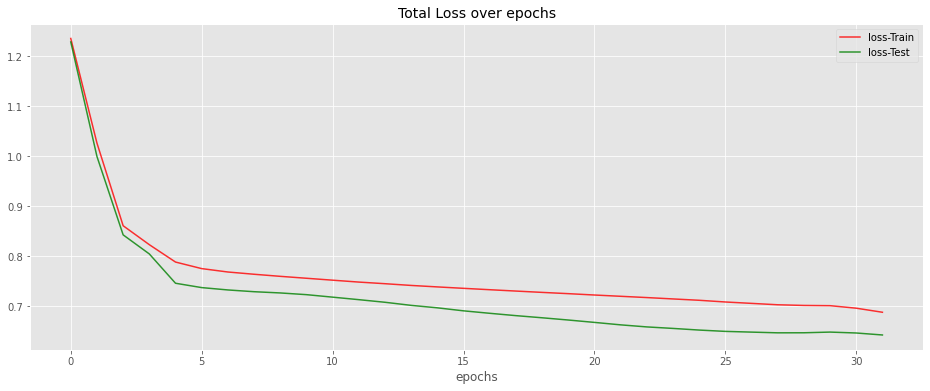

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['total_loss'],color='red', alpha=0.8, label='loss-Train')
plt.plot(history_train_4.history['val_total_loss'],color='green', alpha=0.8, label='loss-Test')
plt.title("Total Loss over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


**Why Training loss higher than Testing loss?**

 * Regularization mechanisms, such as Dropout and weight constraints (Max Norm), are turned off at testing time. They are reflected in the training time loss but not in the test time loss.
 
 * The training loss that Keras displays is the average of the losses for each batch of training data, over the current epoch. Because our model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. This can bring the epoch-wise average down.
 * The testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

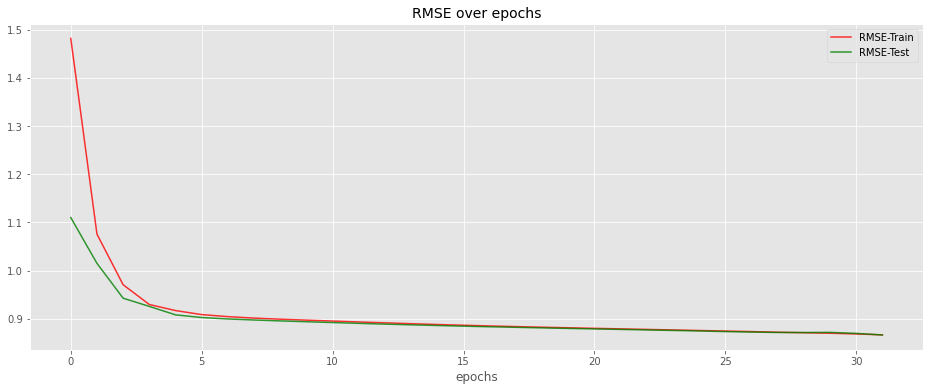

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_4.history['root_mean_squared_error'],color='red', alpha=0.8, label='RMSE-Train')
plt.plot(history_train_4.history['val_root_mean_squared_error'],color='green', alpha=0.8, label='RMSE-Test')
plt.title("RMSE over epochs", fontsize=14)
#plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Evaluate the model
model_4.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 1s 7ms/step - root_mean_squared_error: 0.8665 - loss: 0.7492 - regularization_loss: 0.0000e+00 - total_loss: 0.7492


{'root_mean_squared_error': 0.8664931058883667,
 'loss': 0.6430708765983582,
 'regularization_loss': 0,
 'total_loss': 0.6430708765983582}

## 6. Ranking Tuning Summary

As shown below, we managed to reduce RMSE and loss from 93% to 86.89% and 81% to 64% respectively using below: 

 * Increased embedding_dimension from 32 ==> 64.
 * Increased epochs from 3 ==> 32
 * Increase Dense Layers from 2 ==> 4
 * Adding Dropout + Adding Max Norm
 
 
 |Ranking Tuning | RMSE | loss |
 |:--:|:--:|:--:|
 |Baseline Model: 2 Dense Layers + embedding_dimension = 32 + epochs = 3|0.931866|0.810238|
 |Model 1: 2 Dense Layers + embedding_dimension = 64 + epochs = 32|0.898368|0.853799|
 |Model 2: Deeper: 3 Dense Layers + embedding_dimension = 64 + epochs = 32|0.873792|0.805714|
 |Model 3: Deeper: 4 Dense Layers + embedding_dimension = 64 + epochs = 32|0.868916|0.65914|
 |Model 4: Deeper: 4 Dense Layers + embedding_dimension = 64 + epochs = 32 + Adding Dropout + Adding Max Norm|0.866493|0.643070|
 
 

## 7. Ranking

Finally, let's take five movies from the test sets and see how user number "42" would rank them:

In [ ]:
test_ratings ={}

for m in test.take(5):
    test_ratings[m["movie_title"].numpy()] = RankingModel()((["42"], [m["movie_title"]]))
    
for m in sorted(test_ratings, key=test_ratings.get, reverse=True):
    print(m)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


b'Strange Days (1995)'
b'Cyrano de Bergerac (1990)'
b"Hang 'em High (1967)"
b'My Science Project (1985)'
b"Guess Who's Coming to Dinner (1967)"


As we can see above, we managed to get the predicted ratings for those five movies, and then we sort them in descending order. In practice, we would be sorting the candidates generated from the retrieval stage.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))